# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Import essential libraries
import zipfile
import os
import gdown
import random
import datetime
import itertools
import json
from collections import Counter

Load the dataset.

In [3]:
# Load and unzip the dataset

file_id = "1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

# downloading it in the local storage
gdown.download(url, output, quiet=False, use_cookies=True)

zip_path = "/content/data.zip"
extract_path = "/content/"  # You can set this to any path under /content

# unzipping the file in the /content path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Downloading...
From (original): https://drive.google.com/uc?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM
From (redirected): https://drive.google.com/uc?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM&confirm=t&uuid=ec8cc2c4-3722-431b-9202-1f65a55e762b
To: /content/data.zip
100%|██████████| 501M/501M [00:08<00:00, 61.8MB/s]


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
def load_raw_images(filepath):
    img = Image.open(filepath)
    img = img.convert("RGB")
    return img

# Path containing the image files
files_path = extract_path + "data"

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Function to load images and their labels
def load_images_and_labels(files_path):
    image_array = []
    label_array = []

    for label_dir in os.listdir(files_path):
        label_path = os.path.join(files_path, label_dir)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                try:
                    image = load_raw_images(image_path)
                    image_array.append(image)
                    label_array.append(label_dir)
                except Exception as e:
                    print(f"Error loading image: {image_path}, Error: {e}")

    return image_array, label_array


In [6]:
# Get the images and their labels
image_array, label_array = load_images_and_labels(files_path)

# Find unique labels
unique_labels = set(label_array)
num_labels = len(unique_labels)

# Verify the loaded data
print(f"Total number of images loaded: {len(image_array)}")
print(f"Total number of labels loaded: {len(label_array)}")
print(f"Unique labels: {unique_labels}")

Total number of images loaded: 7625
Total number of labels loaded: 7625
Unique labels: {'Glass', 'Metal', 'Other', 'Food_Waste', 'Cardboard', 'Plastic', 'Paper'}


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Glass: 750
Food_Waste: 1000
Cardboard: 540
Plastic: 2295
Other: 1010
Paper: 1030
Metal: 1000


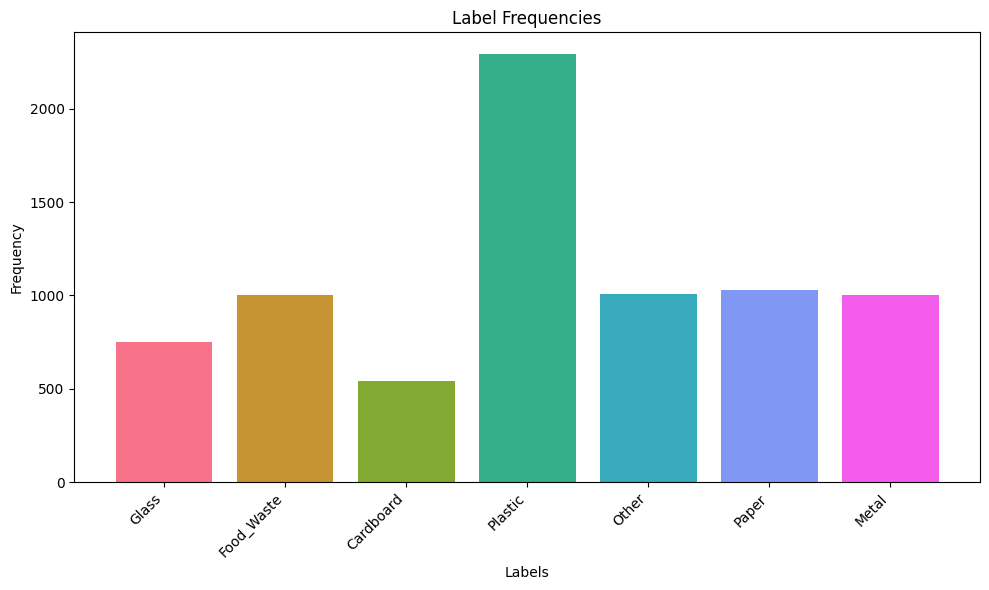

In [7]:
# Visualise Data Distribution

def bar_plot_class_distribution(plot_title, label_title, labels, frequency_title,
                                frequencies, rotation_agle):

    # Generate a color palette with distinct colors for each bar
    colors = sns.color_palette("husl", len(labels))

    plt.figure(figsize=(10, 6)) # Adjust figure size as needed
    plt.bar(labels, frequencies, color=colors)
    plt.xlabel(label_title)
    plt.ylabel(frequency_title)
    plt.title(plot_title)
    plt.xticks(rotation=rotation_agle, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()

def plot_label_frequencies(label_array):
    label_frequencies = Counter(label_array)
    labels = list(label_frequencies.keys())
    frequencies = list(label_frequencies.values())
    # Print the frequencies and labels together
    for label, frequency in zip(labels, frequencies):
        print(f"{label}: {frequency}")
    # Draw Bar Graph for Label Frequencies
    bar_plot_class_distribution("Label Frequencies", "Labels", labels, "Frequency", frequencies, 45)

plot_label_frequencies(label_array)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [8]:
# Visualise Sample Images (across different labels)

def display_images(image_array, label_array, num_images_per_label=5):
    for label in unique_labels:
        indices = np.where(label_array == label)[0][:num_images_per_label]

        # Plot 5 images in a row
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, 5, i + 1)
            plt.imshow(image_array[idx])
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

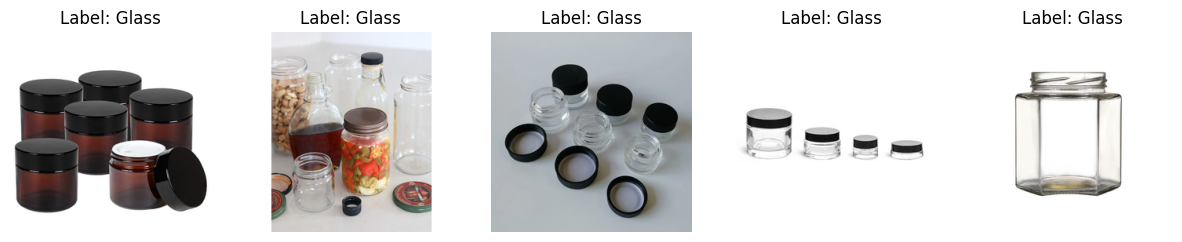

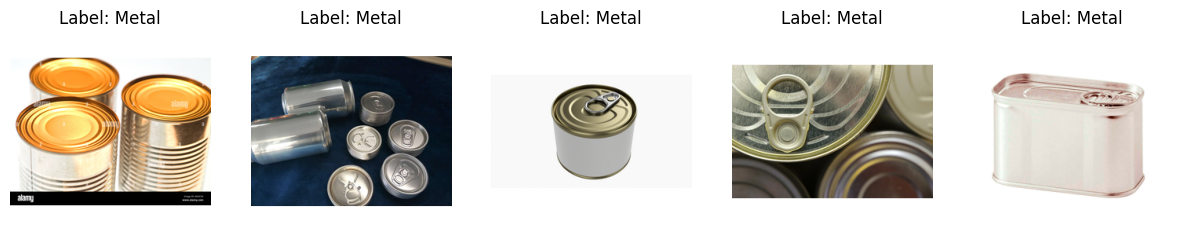

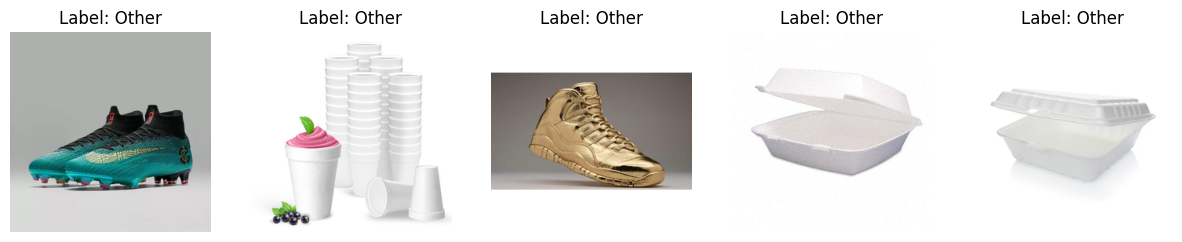

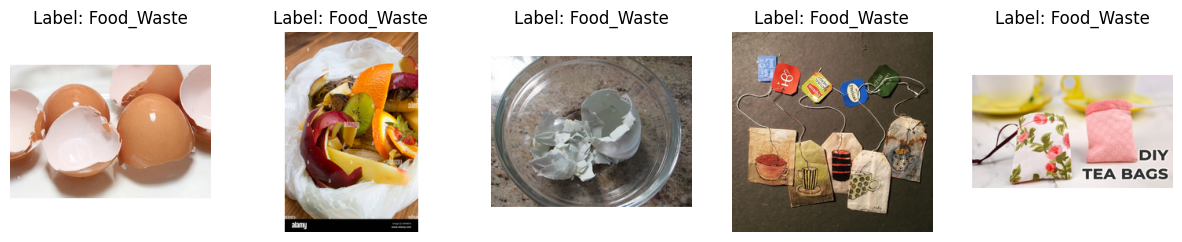

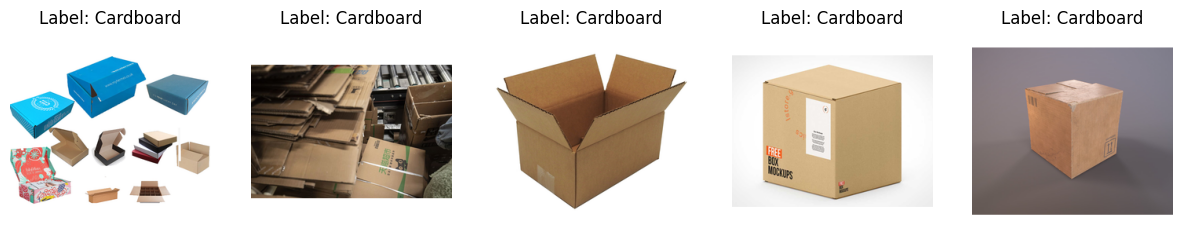

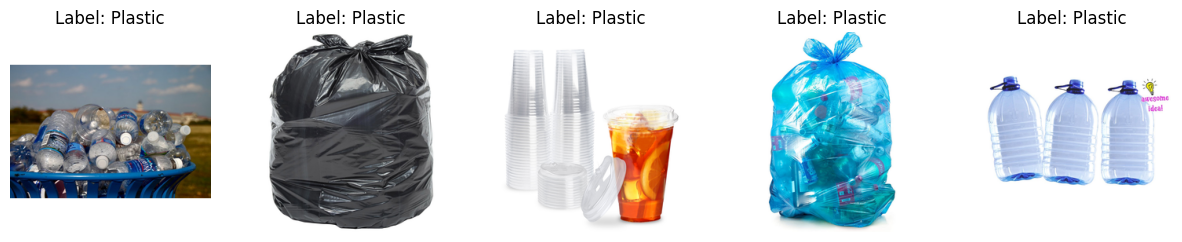

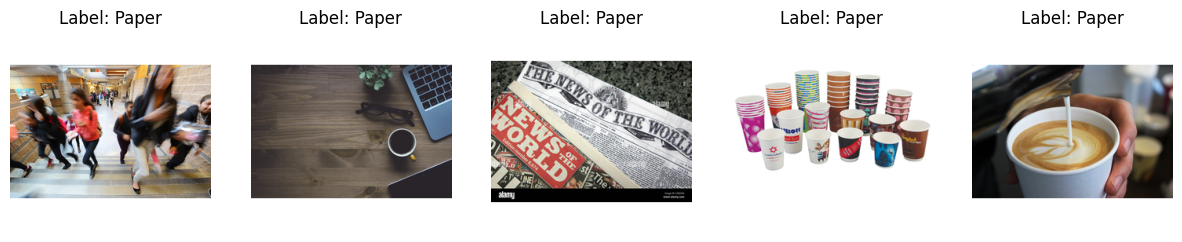

In [9]:
# Ensure label_array is at least 1D
label_array = np.atleast_1d(label_array)
# Display 5 Unique Images per Label
display_images(image_array, label_array)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [10]:
# Find the smallest and largest image dimensions from the data set
min_width=float('inf')
min_height=float('inf')
max_width=0
max_height=0

for image in image_array:
    width, height = image.size
    min_width = min(min_width, width)
    min_height = min(min_height, height)
    max_width = max(max_width, width)
    max_height = max(max_height, height)

print(f"min_width: {min_width} min_height: {min_height} max_width: {max_width} max_height: {max_height}")

min_width: 256 min_height: 256 max_width: 256 max_height: 256


In [11]:
# Resize the image dimensions
def center_crop(image, crop_size):
    width, height = image.size
    new_width, new_height = crop_size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    return image.crop((left, top, right, bottom))

crop_size = (224, 224)

#cropped_images = [center_crop(img, crop_size) for img in image_array]
cropped_images = [img.resize((224, 224)) for img in image_array]

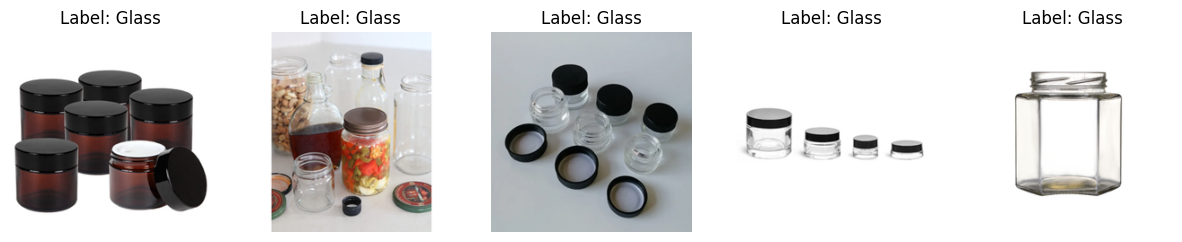

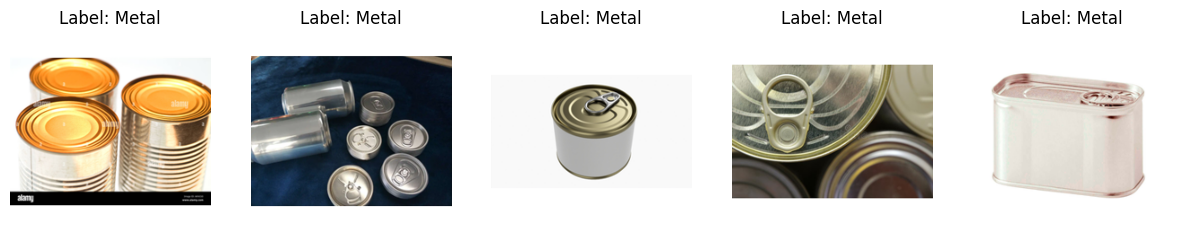

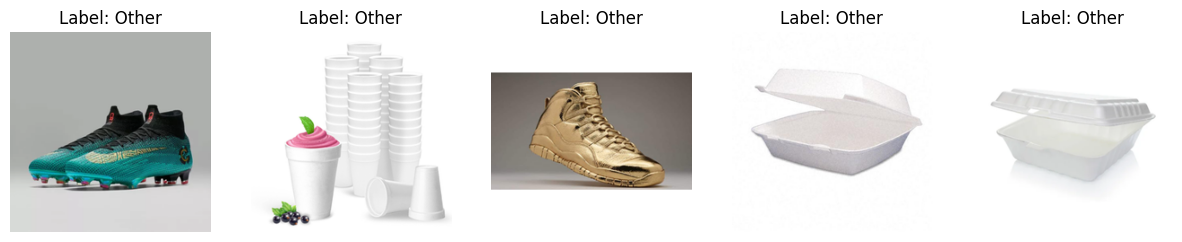

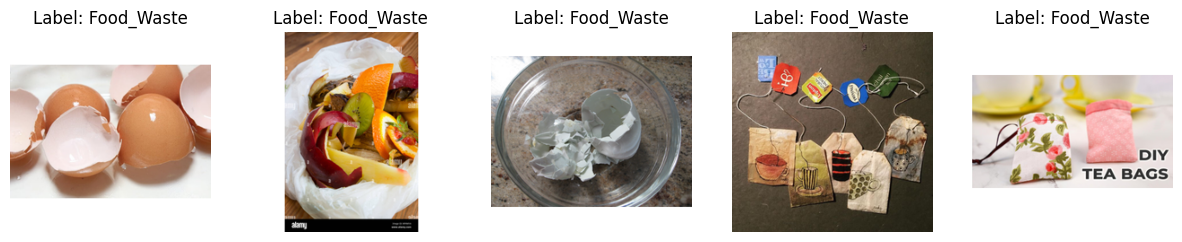

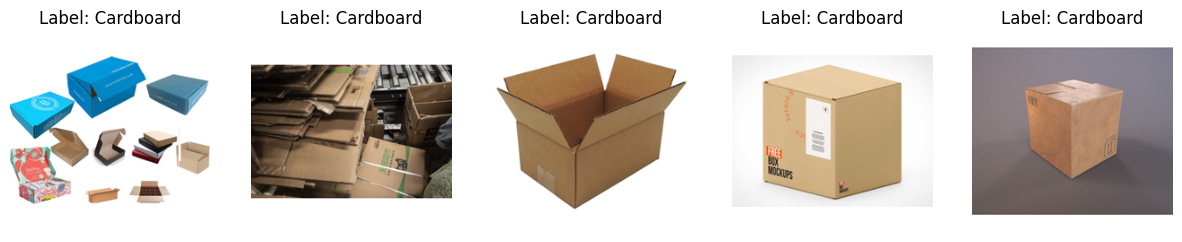

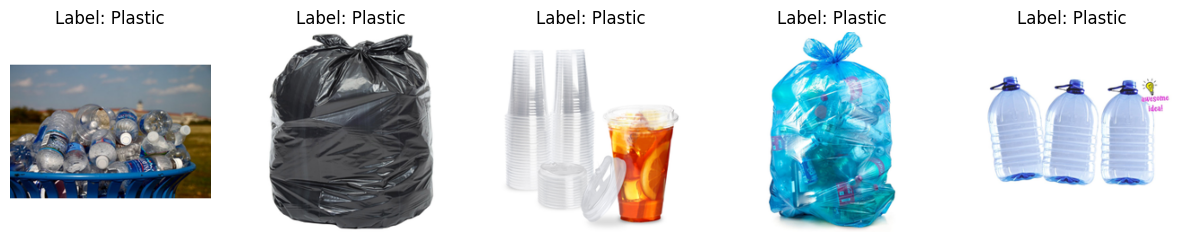

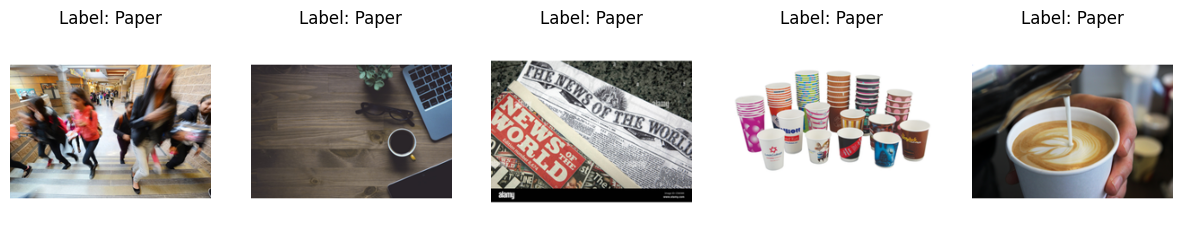

In [12]:
# Display 5 Unique Croped Images per Label
display_images(cropped_images, label_array)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [13]:
# Encode the labels suitably
labelencoder = LabelEncoder()
encoded_labels = labelencoder.fit_transform(label_array)
label_map = {encoded: label for encoded, label in enumerate(labelencoder.classes_)}
label_map

{0: np.str_('Cardboard'),
 1: np.str_('Food_Waste'),
 2: np.str_('Glass'),
 3: np.str_('Metal'),
 4: np.str_('Other'),
 5: np.str_('Paper'),
 6: np.str_('Plastic')}

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [14]:
# Assign specified parts of the dataset to train and validation sets
X = np.stack([np.array(img) for img in cropped_images])  # shape: (N, 224, 224, 3)
y = np.array(encoded_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42,stratify=encoded_labels)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.176,
                                                  stratify=y_train, random_state = 42)


datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(np.array(X_train), y_train, batch_size=32, shuffle=True)
test_generator = datagen.flow(np.array(X_test), y_test, batch_size=32, shuffle=False)
val_generator = datagen.flow(np.array(X_val), y_val, batch_size=32, shuffle=False)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [15]:
# Conv layer variants (3-layer conv blocks only)
conv_layer_variants = [
    {
        "filters": [32, 64, 128],
        "dropouts": [0.25, 0.35, 0.5]
    },
    {
        "filters": [64, 128, 256],
        "dropouts": [0.3, 0.4, 0.5]
    }
]

# Other Options
batch_norm_options = [True, False]
use_gap_options = [False]
dense_units_options = [
    [128],
    [256, 128]
]
dense_dropout_rates = [0.25, 0.4]
l2_regs = [0.0001]
learning_rates = [0.0005]

# Generate all combinations
non_conv_combinations = list(itertools.product(
    batch_norm_options,
    use_gap_options,
    dense_units_options,
    dense_dropout_rates,
    l2_regs,
    learning_rates
))

In [16]:
# Generate Custom CNN Layer Configurations
def generate_cnn_configs():
    configs = []
    model_id = 1

    for variant in conv_layer_variants:
        filters = variant["filters"]
        dropouts = variant["dropouts"]

        conv_layers = [
            {
                "filters": filters[i],
                "kernel_size": (3, 3),
                "pool_size": (2, 2),
                "dropout_rate": dropouts[i]
            } for i in range(3)
        ]

        for (
            batch_norm,
            use_gap,
            dense_units,
            dense_dropout_rate,
            l2_reg,
            learning_rate
        ) in non_conv_combinations:

            config = {
                "model_name": f"cnn_model_{model_id}",
                "conv_layers": conv_layers,
                "batch_norm": batch_norm,
                "use_gap": use_gap,
                "dense_units": dense_units,
                "dense_dropout_rate": dense_dropout_rate,
                "l2_reg": l2_reg,
                "activation_dense": "relu",
                "final_activation": "softmax",
                "kernel_initializer": "he_uniform",
                "optimizer": "adam",
                "learning_rate": learning_rate
            }

            configs.append(config)
            model_id += 1

    return configs

In [17]:
# Function to generate Convolution Block with params
def conv_block(block, layer_config, input_shape=None):

      filters = layer_config.get("filters", 32)
      kernel_size = layer_config.get("kernel_size", (3, 3))
      activation = layer_config.get("activation", 'relu')
      use_batchnorm = layer_config.get("batch_norm", True)
      use_maxpool = True  # Always True unless specified
      pool_size = layer_config.get("pool_size", (2, 2))
      use_dropout = True
      dropout_rate = layer_config.get("dropout_rate", 0.25)

      if input_shape:
          block.add(Conv2D(filters, kernel_size, padding='same', input_shape=input_shape, kernel_initializer='he_uniform'))
      else:
          block.add(Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_uniform'))

      if use_batchnorm:
          block.add(BatchNormalization())

      block.add(Activation(activation))

      if use_maxpool:
          block.add(MaxPooling2D(pool_size=pool_size))

      if use_dropout:
          block.add(Dropout(dropout_rate))

      return block

In [18]:
# Function to generate model using various params
def build_model(input_shape, num_labels, config):

    model = Sequential()

    conv_layers = config.get("conv_layers", [])
    use_gap = config.get("use_gap", True)
    dense_units = config.get("dense_units", [128])
    dense_dropout_rate = config.get("dense_dropout_rate", 0.25)
    l2_reg = config.get("l2_reg", 0.0001)
    activation_dense = config.get("activation_dense", "relu")
    final_activation = config.get("final_activation", "softmax")
    kernel_init = config.get("kernel_initializer", "he_uniform")
    learning_rate = config.get("learning_rate", 0.001)

     # Ensure that dense_dropout_rate is always a list
    if isinstance(dense_dropout_rate, float):
        dense_dropout_rate = [dense_dropout_rate] * len(dense_units)

    # Add convolution blocks
    for index, layer_cfg in enumerate(conv_layers):
        in_shape = input_shape if index == 0 else None
        model = conv_block(model, layer_cfg, input_shape=in_shape)

    # GAP or Flatten
    if use_gap:
        model.add(GlobalAveragePooling2D())
    else:
        model.add(Flatten())

    # Dense Layers
    for i, units in enumerate(dense_units):
        model.add(Dense(units,
                        activation=None,
                        kernel_initializer=kernel_init,
                        kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Activation(activation_dense))
        model.add(Dropout(dense_dropout_rate[i] if i < len(dense_dropout_rate) else 0.25))


    # Output layer
    model.add(Dense(num_labels, activation=final_activation))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
# Build and compile the model

cnn_configs = generate_cnn_configs()
print(len(cnn_configs))
print(cnn_configs)
input_size = (224, 224, 3)
num_classes = 7

models= []
i=-1
# Build all models
for config in cnn_configs:
    i = i+1
    model = build_model(input_size, num_classes, config)
    models.append({
            "id": f"expriment_{i}",
            "model": model,
            "config": config
            })

16
[{'model_name': 'cnn_model_1', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.25, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'softmax', 'kernel_initializer': 'he_uniform', 'optimizer': 'adam', 'learning_rate': 0.0005}, {'model_name': 'cnn_model_2', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.4, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'so

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Use appropriate metrics and callbacks as needed.

In [20]:
# Training

epoch=20
batch_size=32

histories = []

#Train all models
for entry in models:
    model = entry["model"]
    config = entry["config"]
    print(f"Training model with config: {config}")
    checkpoint_path = f"models/{entry['id']}.keras"
    callbacks = [
                    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True),
                    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
                ]
    history = entry["model"].fit(train_generator, validation_data=val_generator, epochs=epoch,callbacks=callbacks, verbose=0)
    entry["checkpoint_path"] = checkpoint_path
    entry["history"] = history
    histories.append(history)

Training model with config: {'model_name': 'cnn_model_1', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.25, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'softmax', 'kernel_initializer': 'he_uniform', 'optimizer': 'adam', 'learning_rate': 0.0005}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training model with config: {'model_name': 'cnn_model_2', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.4, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'softmax', 'kernel_initializer': 'he_uniform', 'optimizer': 'adam', 'learning_rate': 0.0005}
Training model with config: {'model_name': 'cnn_model_3', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [256, 128], 'dense_dropout_rate': 0.25, 'l2_reg': 0.0

In [21]:
print(entry["history"].history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [22]:
best_val_acc = 0
best_model_path = "best_cnn_model.keras"
best_config = None
results = []

# Evaluate all models
for entry in models:
    history = entry["history"].history

    train_acc = max(history['accuracy'])
    val_acc = max(history['val_accuracy']) if 'val_accuracy' in history else 0.0

    test_loss, test_acc = entry["model"].evaluate(test_generator, verbose=0)

    result = {
        "experiment_id": entry["id"],
        "conv_layers": entry["config"]["conv_layers"],
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "test_accuracy": test_acc
    }
    results.append(result)

    # Use validation accuracy to select best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = result
        entry["model"].save(best_model_path)

# Display results
results_df = pd.DataFrame(results)
print("\nBest Configuration (based on validation accuracy):")
print(best_config)


Best Configuration (based on validation accuracy):
{'experiment_id': 'expriment_13', 'conv_layers': [{'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.3}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.4}, {'filters': 256, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'train_accuracy': 0.9039325714111328, 'val_accuracy': 0.6406660676002502, 'test_accuracy': 0.5821678042411804}


In [23]:
# Load best saved model

best_model = load_model(best_model_path)

# Predict on test set
y_true = test_generator.y
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Labels
class_labels = ['Other', 'Paper', 'Food_Waste', 'Metal', 'Plastic', 'Cardboard', 'Glass']

# Generate evaluation report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

Classification Report:
               precision    recall  f1-score   support

       Other       0.60      0.73      0.66        81
       Paper       0.54      0.75      0.63       150
  Food_Waste       0.55      0.39      0.46       112
       Metal       0.72      0.51      0.60       150
     Plastic       0.43      0.45      0.44       152
   Cardboard       0.58      0.45      0.51       155
       Glass       0.63      0.69      0.66       344

    accuracy                           0.58      1144
   macro avg       0.58      0.57      0.56      1144
weighted avg       0.59      0.58      0.58      1144



## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [24]:
# Define augmentation steps to augment images

# To Augement the Images we will define the ReScale, Rotation, width and height Shift, Shear and Zoom update
# and finally Flip the original Images

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [25]:
# Create a function to augment the images
train_augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for val and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
# Create the augmented training dataset

train_generator = train_augmented_datagen.flow(
    X_train, y_train, batch_size=32, shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False
)

test_generator = val_test_datagen.flow(
    X_test, y_test, batch_size=32, shuffle=False
)

In [27]:
# Train the model using augmented images

model = build_model((22,224,3), 7, best_config)  # assumes best_config is defined
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Step 5: Save the model
model.save("best_cnn_model_augmented.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 63s 335ms/step - accuracy: 0.3030 - loss: 1.9627 - val_accuracy: 0.2778 - val_loss: 1.8546
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - accuracy: 0.3994 - loss: 1.6170 - val_accuracy: 0.3918 - val_loss: 1.6277
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - accuracy: 0.4134 - loss: 1.5842 - val_accuracy: 0.3734 - val_loss: 1.6597
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - accuracy: 0.4383 - loss: 1.5132 - val_accuracy: 0.4251 - val_loss: 1.5365
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - accuracy: 0.4480 - loss: 1.5045 - val_accuracy: 0.4181 - val_loss: 1.5776
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - accuracy: 0.4813 - loss: 1.4405 - val_accuracy: 0.1972 - val_loss: 3.5537
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.4679 - loss: 1.4593 - val_accuracy: 0.3602 - val_loss: 1.7530
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 305ms/step - accuracy: 0.4943 - loss: 1

In [28]:
# Load model
best_model = load_model("best_cnn_model_augmented.keras")

# Get ground-truth labels and predictions
# Predict on test set
y_true = test_generator.y  # True labels
y_pred_probs = best_model.predict(test_generator)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# Metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

Classification Report:

              precision    recall  f1-score   support

       Other       0.93      0.17      0.29        81
       Paper       0.54      0.48      0.51       150
  Food_Waste       0.00      0.00      0.00       112
       Metal       0.43      0.08      0.13       150
     Plastic       0.11      0.02      0.03       152
   Cardboard       0.19      0.70      0.30       155
       Glass       0.50      0.54      0.52       344

    accuracy                           0.35      1144
   macro avg       0.39      0.29      0.26      1144
weighted avg       0.38      0.35      0.31      1144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### **4.1.2**

Train the model on the new augmented dataset.

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data

  1. All images in the dataset were initially loaded at a uniform resolution of 256×256 pixels.

  2. Among all categories, "Plastic" had the highest number of labeled samples.

  3. All images were rescaled to 224×224 pixels to maintain consistency with the input requirements of the CNN model.

  4. The dataset was partitioned into training, validation, and test sets to enable proper model development and evaluation.

* Report model training results
  1. A custom configuration approach was used to generate and train 16 different CNN model variants.

  2. After training and evaluation, the best-performing model achieved the following accuracy scores:

    *  Training Accuracy: 90.39%

    *  Validation Accuracy: 64.07%

    *  Test Accuracy: 58.22%

  3. The selected model was further evaluated using classification metrics:

        * Precision: 0.59

        * Recall: 0.58

        * F1-Score: 0.58

  4. Subsequently, the best model was re-evaluated using augmented image data. The classification performance was observed as:

      * Precision: 0.38

      * Recall: 0.35

      * F1-Score: 0.31